In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns
import cvxpy as cp
import warnings
from sklearn.linear_model import LinearRegression

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
warnings.filterwarnings('ignore')

### Step 1

In [2]:
tickers = ['AAPL', 'JNJ', 'V', 'PG', 'XOM']

start_date = '2021-01-01'
end_date = '2021-09-01'

data = yf.download(tickers, start_date, end_date)['Adj Close']
risk_free = yf.download("^IRX", start_date, end_date)["Adj Close"].apply(lambda x: (1 + x) ** (1/365) - 1)
risk_free.name = 'Risk free rate'

print(data.shape)
data.sample(5)

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed
(167, 5)


,AAPL,JNJ,PG,V,XOM
Date,,,,,
2021-01-27,139.41673,153.69463,119.13770,190.45444,39.37020
2021-07-07,142.33339,157.03615,127.95054,235.14658,54.11201
2021-08-20,146.11597,166.33357,136.35840,226.99033,47.95668
2021-01-20,129.57335,148.65936,121.69806,201.23875,42.99903
2021-07-09,142.86502,157.35133,127.97856,233.64754,54.84653


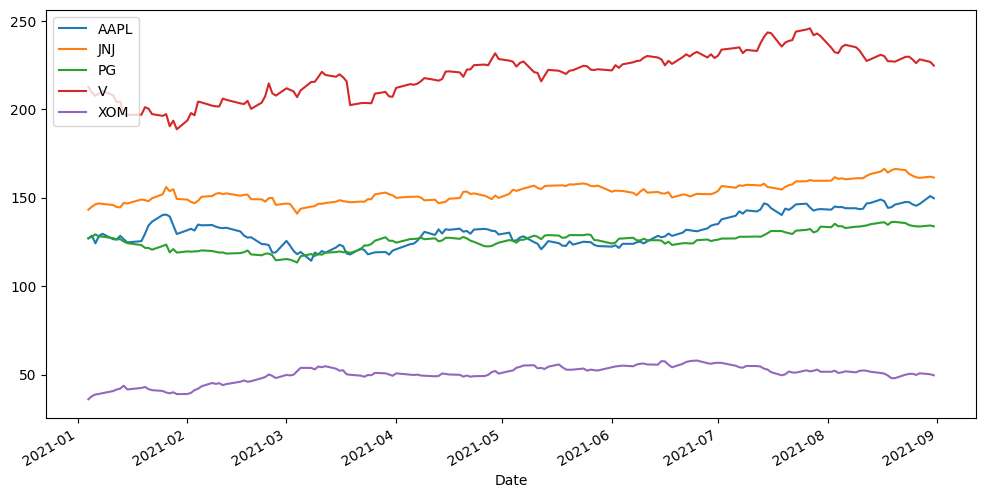

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);

In [4]:
returns = np.log(data / data.shift(1))
returns.dropna(inplace=True)
returns.sample(5)

,AAPL,JNJ,PG,V,XOM
Date,,,,,
2021-03-09,0.03985,0.00190,-0.00892,0.00041,-0.01556
2021-07-02,0.01941,0.01803,0.00487,0.01469,-0.00142
2021-07-22,0.00958,0.00289,-0.00384,0.00197,-0.01132
2021-03-15,0.02416,0.00512,0.00327,-0.00487,-0.02583
2021-04-01,0.00693,-0.00929,-0.00853,0.02394,0.02756


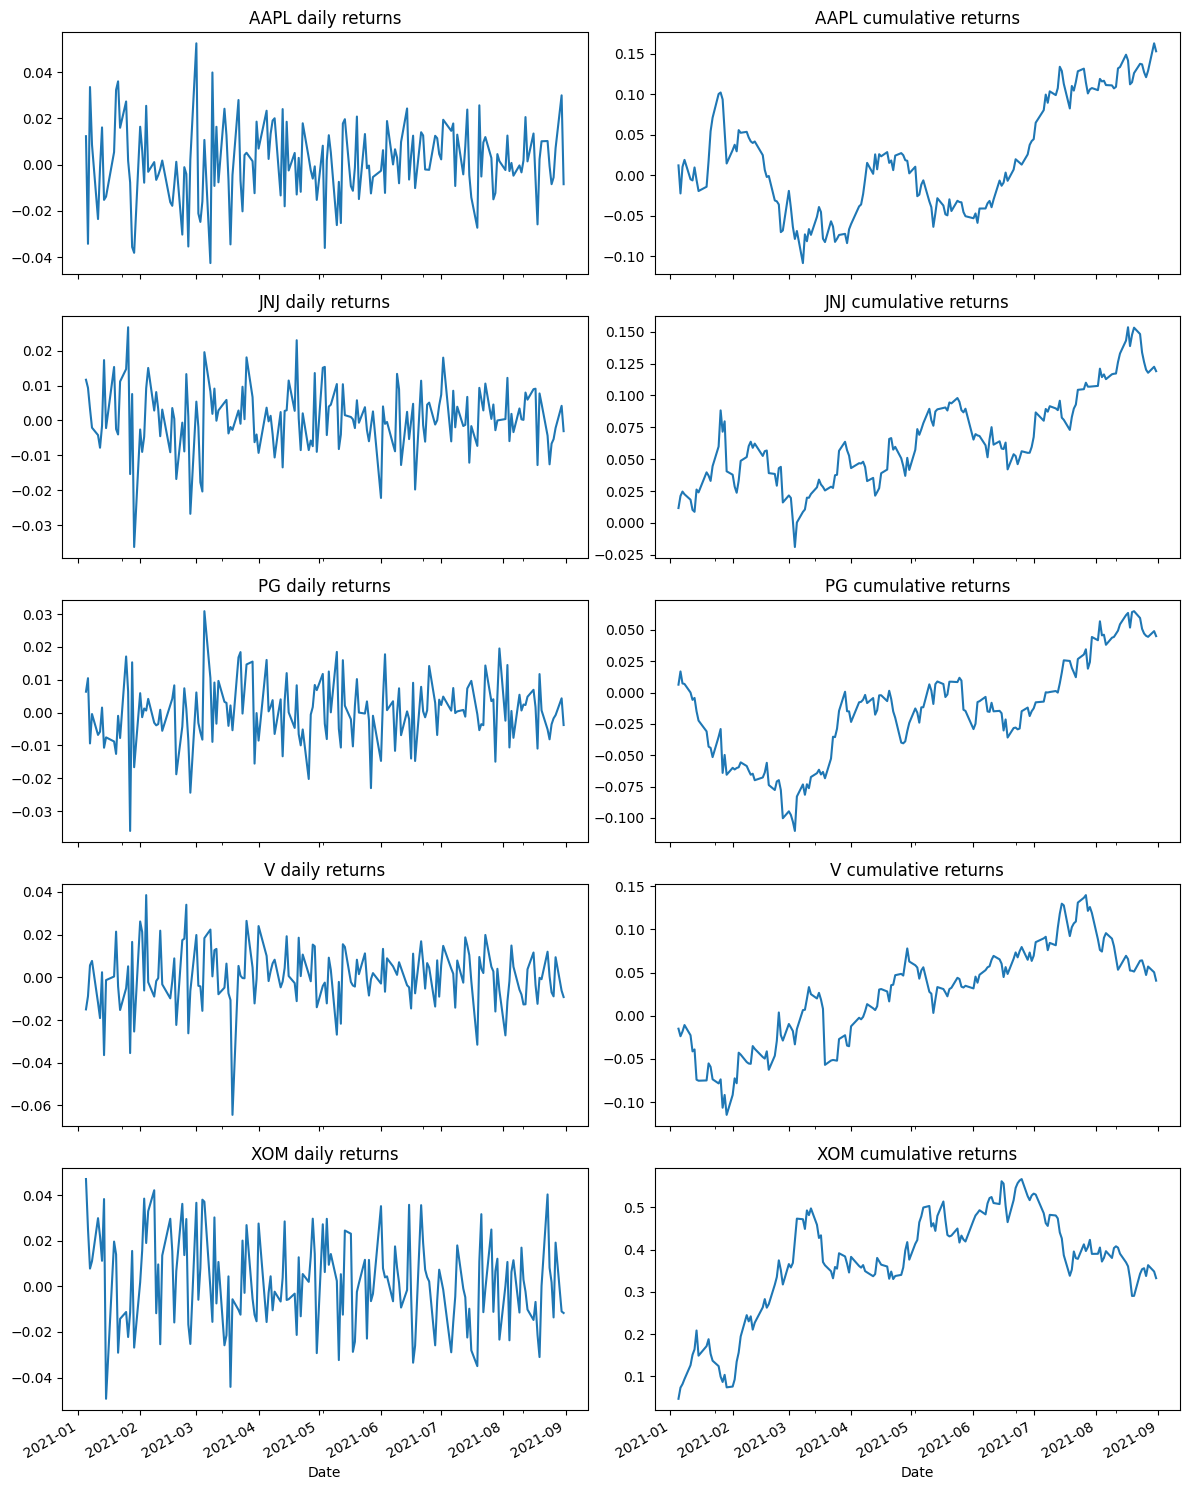

In [5]:
def plot_returns(df):
    if isinstance(df, pd.DataFrame):
        n = df.shape[1]
        fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(12, n*3))
        for i, j in enumerate(df):
            df[j].plot(ax=ax[i][0], title=f'{j} daily returns')
            ((df[j] + 1).cumprod() - 1).plot(ax=ax[i][1], title=f'{j} cumulative returns')
            ax[i][0].sharex(ax[0][0])
            ax[i][1].sharex(ax[0][1])
        fig.tight_layout();
    if isinstance(df, pd.Series):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
        df.plot(ax=ax[0], title=f'{df.name} daily returns')
        ((df + 1).cumprod() - 1).plot(ax=ax[1], title=f'{df.name} cumulative returns')
        fig.tight_layout();



plot_returns(returns)

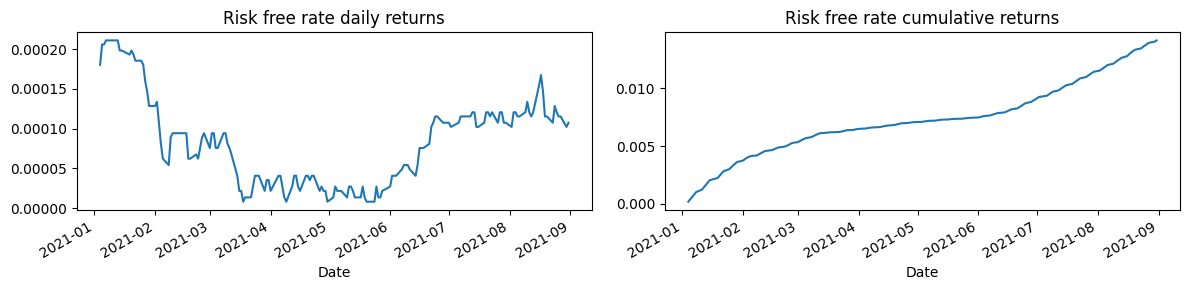

In [6]:
plot_returns(risk_free)

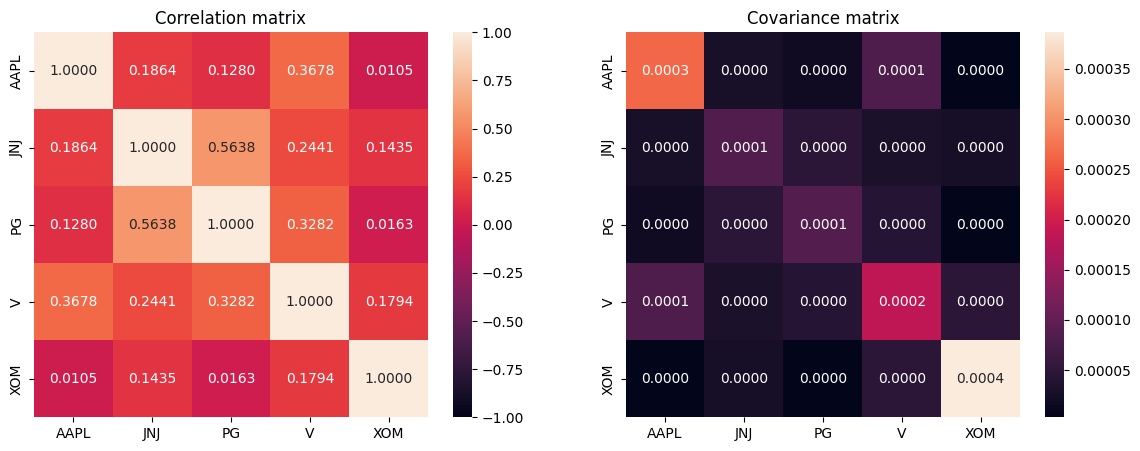

In [7]:
corr_matrix = returns.corr()
cov_matrix = returns.cov()

fig, ax = plt.subplots(ncols=2, figsize=(14,5))
sns.heatmap(corr_matrix, ax=ax[0], annot=True, fmt='.4f', vmin=-1, vmax=1)
sns.heatmap(cov_matrix, ax=ax[1], annot=True, fmt='.4f')
ax[0].set_title('Correlation matrix')
ax[1].set_title('Covariance matrix');

### Step 2

In [8]:
def random_portfolios(returns, n=2000):
    portfolio_returns = np.zeros(n)
    portfolio_risk = np.zeros(n)
    for i in range(n):
        weights = np.random.rand(returns.shape[1])
        weights /= sum(weights)
        portfolio_returns[i] = np.dot(returns.mean(), weights)
        portfolio_risk[i] = np.sqrt(np.dot(weights, np.dot(returns.cov(), weights)))
    return portfolio_returns, portfolio_risk

def efficient_frontier(returns):
    n_assets = returns.shape[1]
    weights_mvp = cp.Variable(n_assets)
    returns_mvp = np.array(returns.mean()) @ weights_mvp
    risk_mvp = cp.quad_form(weights_mvp, np.array(returns.cov()))
    objective_mvp = cp.Minimize(risk_mvp)
    constraints_mvp = [cp.sum(weights_mvp) == 1, weights_mvp >= 0]
    problem_mvp = cp.Problem(objective_mvp, constraints_mvp)
    problem_mvp.solve()
    min_returns = np.dot(returns.mean(), weights_mvp.value)
    max_returns = np.max(returns.mean())
    n_points = 100
    optimal_weights = np.zeros((n_points, n_assets))
    optimal_returns = np.linspace(min_returns, max_returns, n_points)
    optimal_risk = np.zeros(n_points)

    for i, exp_return in enumerate(optimal_returns):
        weights_ef = cp.Variable(n_assets)
        returns_ef = np.array(returns.mean()) @ weights_ef
        risk_ef = cp.quad_form(weights_ef, returns.cov())
        objective = cp.Minimize(1/2 * risk_ef - returns_ef)
        constraints = [cp.sum(weights_ef) == 1, weights_ef >= 0, returns_ef <= exp_return]

        problem = cp.Problem(objective, constraints)
        problem.solve()

        if weights_ef.value is not None:
            optimal_weights[i] = weights_ef.value.flatten()
            optimal_risk[i] = np.sqrt(np.dot(weights_ef.value.T, np.dot(cov_matrix, weights_ef.value)))

    return optimal_returns, optimal_risk

def plot(returns, weights_df):
    temp1 = weights_df.copy()
    temp2 = weights_df.copy()
    temp1[returns.columns] = np.eye(returns.shape[1])
    mean_returns = np.zeros(temp1.shape[1])
    risk = np.zeros(temp1.shape[1])
    for i in range(temp1.shape[1]):
        mean_returns[i] = np.dot(returns.mean(), temp1.iloc[:,i])
        risk[i] = np.sqrt(np.dot(np.dot(temp1.iloc[:,i].T, returns.cov()), temp1.iloc[:,i]))
    eff_returns, eff_risk = efficient_frontier(returns)

    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    rand_returns, rand_risk = random_portfolios(returns)
    sns.scatterplot(x=rand_risk,
                    y=rand_returns,
                    hue=rand_returns,
                    palette='YlOrBr',
                    alpha=0.5,
                    legend=False,
                    ax=ax[0]
                   )
    ax[0].plot(eff_risk, eff_returns, color='k', linestyle='--', alpha=0.5, label='Efficient Frontier')

    for i in range(len(mean_returns)):
        ax[0].scatter(x=risk[i],
                      y=mean_returns[i],
                      marker='*',
                      s=100,
                      label=temp1.columns[i]
                     )
    ax[0].set_xlabel('Portfolio Risk')
    ax[0].set_ylabel('Portfolio Return')
    ax[0].set_title('Frontier')
    ax[0].legend(ncol=3, loc='upper left', bbox_to_anchor=(-0.1, -0.1))
    ax[0].grid(False)


    temp2['Asset'] = returns.columns
    weights_melt = pd.melt(temp2, id_vars=['Asset'], var_name='Portfolio', value_name='Weight')
    sns.barplot(x='Asset', y='Weight', hue='Portfolio', data=weights_melt, ax=ax[1])
    ax[1].set_ylim(0, 1)
    ax[1].set_xlabel('Asset')
    ax[1].set_ylabel('Weight')
    ax[1].set_title('Optimal weights')
    ax[1].grid(False);

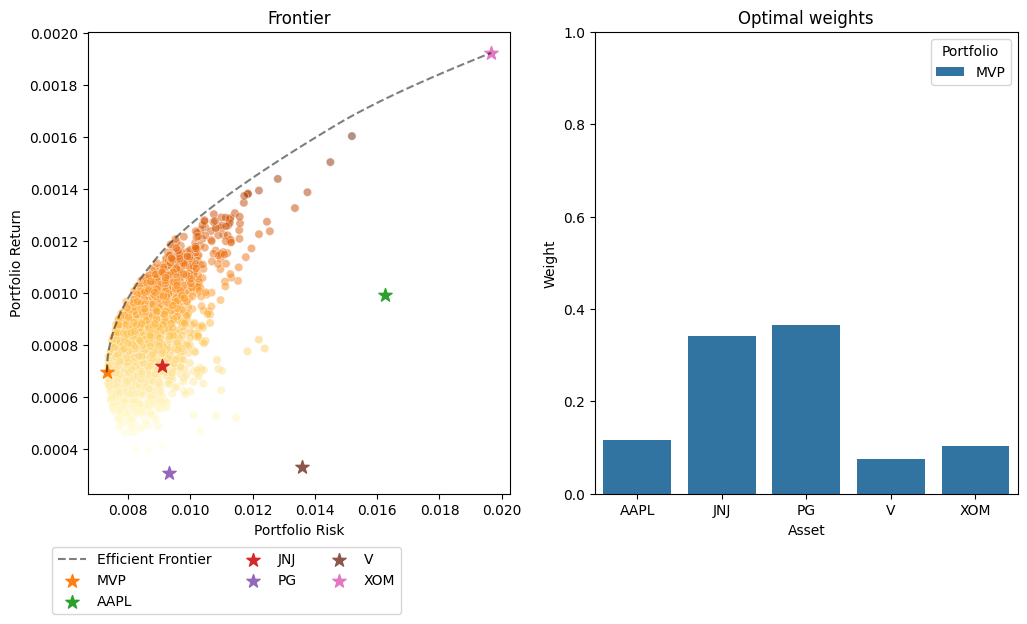

In [9]:
# minimum variance portfolio
n_assets = returns.shape[1]
weights_mvp = cp.Variable(n_assets)
returns_mvp = np.array(returns.mean()) @ weights_mvp
risk_mvp = cp.quad_form(weights_mvp, np.array(cov_matrix))
objective_mvp = cp.Minimize(risk_mvp)
constraints_mvp = [cp.sum(weights_mvp) == 1, weights_mvp >= 0]
problem_mvp = cp.Problem(objective_mvp, constraints_mvp)
problem_mvp.solve()

weights_df = pd.DataFrame()
weights_df['MVP'] = weights_mvp.value
weights_df.index = returns.columns

plot(returns, weights_df)

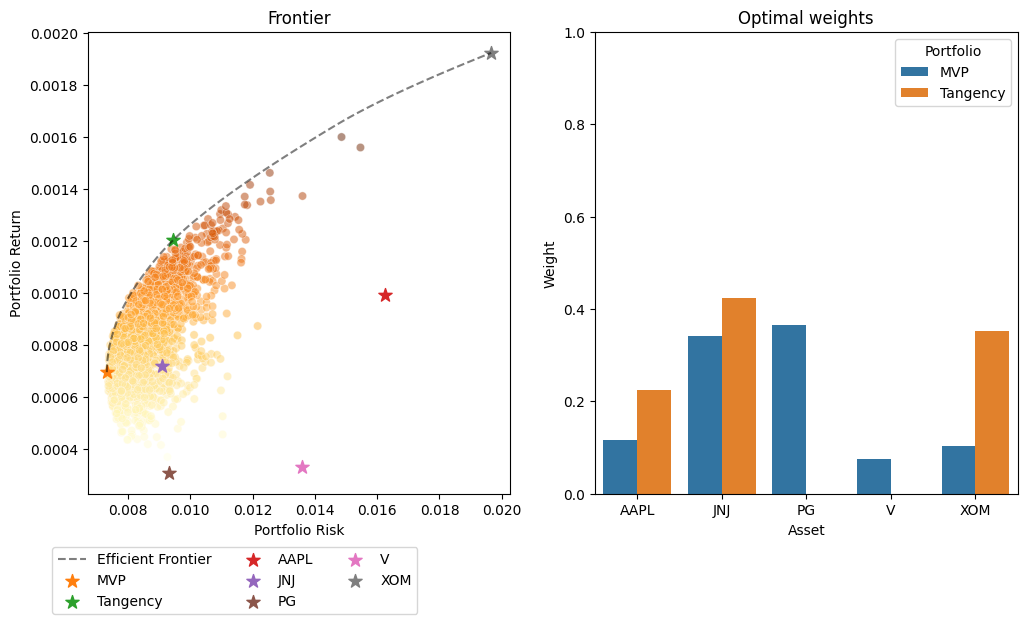

In [10]:
# tangency portfolio
n_assets = returns.shape[1]
weights_mvp = cp.Variable(n_assets)
returns_mvp = np.array(returns.mean()) @ weights_mvp
risk_mvp = cp.quad_form(weights_mvp, np.array(returns.cov()))
objective_mvp = cp.Minimize(risk_mvp)
constraints_mvp = [cp.sum(weights_mvp) == 1, weights_mvp >= 0]
problem_mvp = cp.Problem(objective_mvp, constraints_mvp)
problem_mvp.solve()
min_returns = np.dot(returns.mean(), weights_mvp.value)
max_returns = np.max(returns.mean())
n_points = 100
optimal_weights = np.zeros((n_points, n_assets))
optimal_returns = np.linspace(min_returns, max_returns, n_points)
optimal_risk = np.zeros(n_points)

for i, exp_return in enumerate(optimal_returns):
    weights_ef = cp.Variable(n_assets)
    returns_ef = np.array(returns.mean()) @ weights_ef
    risk_ef = cp.quad_form(weights_ef, returns.cov())
    objective = cp.Minimize(1/2 * risk_ef - returns_ef)
    constraints = [cp.sum(weights_ef) == 1, weights_ef >= 0, returns_ef <= exp_return]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    if weights_ef.value is not None:
            optimal_weights[i] = weights_ef.value.flatten()
            optimal_risk[i] = np.sqrt(np.dot(weights_ef.value.T, np.dot(cov_matrix, weights_ef.value)))

sharpe_ratios = (optimal_returns - risk_free.mean()) / optimal_risk
max_sharpe = np.argmax(sharpe_ratios)

weights_df['Tangency'] = optimal_weights[max_sharpe]

plot(returns, weights_df)

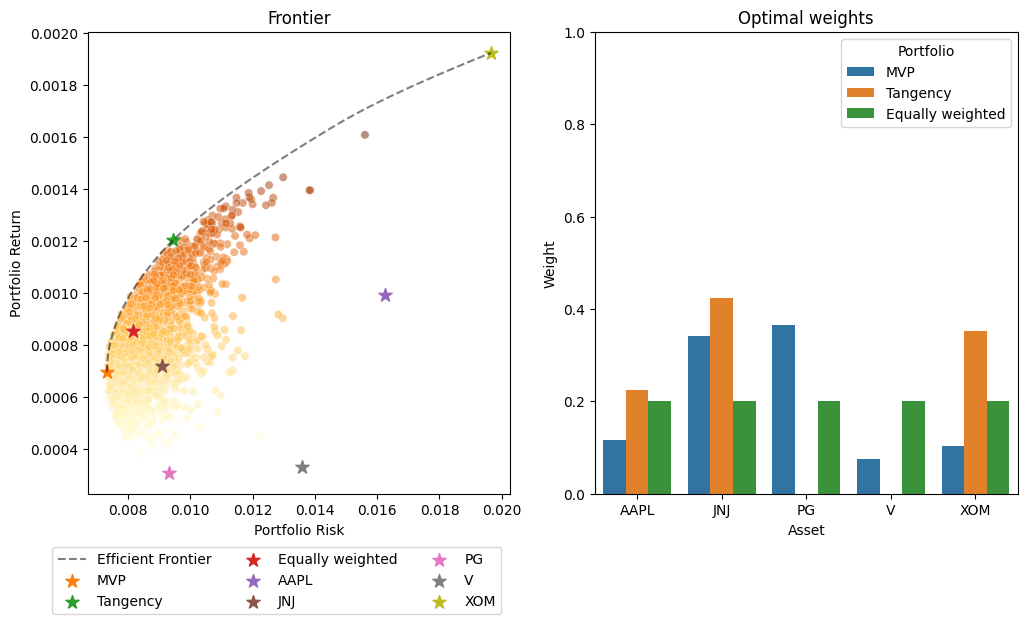

In [11]:
# 1/n
weights_df['Equally weighted'] = [1 / returns.shape[1]] * returns.shape[1]

plot(returns, weights_df)

In [12]:
def plot_cumulative_returns(df):
    fig, ax = plt.subplots(figsize=(16, 8))
    ((df + 1).cumprod() - 1).plot(ax=ax);

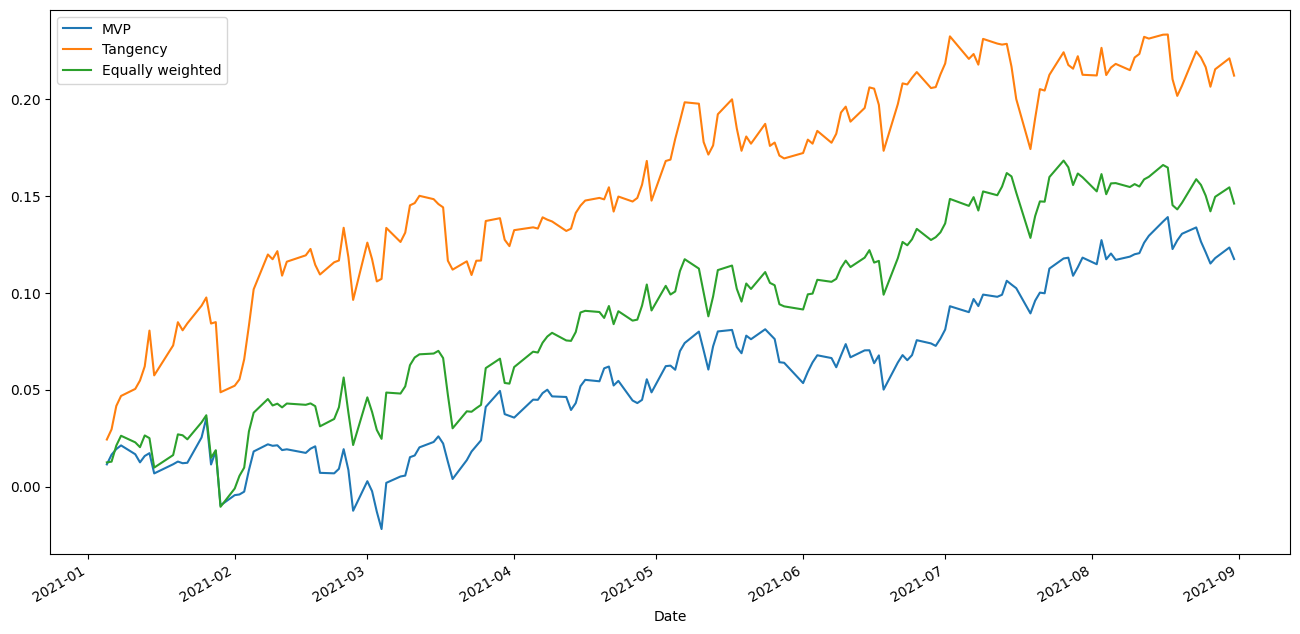

In [13]:
portfolio_returns_df = returns.dot(weights_df)

plot_cumulative_returns(portfolio_returns_df)

### Step 3

In [14]:
# approach 1

np.random.seed(0)

asset_basket = [
    "AAPL", "MSFT", "AMZN", "GOOGL",  # Technology
    "JNJ", "PFE", "MRK", "UNH", "TMO",  # Healthcare
    "V", "MA", "PYPL", "ADP", "AXP",  # Financials
    "PG", "KO", "PEP", "NKE", "HD",  # Consumer Goods
    "XOM", "CVX", "BP",  # Energy
    "DIS", "CMCSA", "NFLX", "NVDA", "EA",  # Entertainment
    "T", "VZ", "TMUS", "AMT", "CCI",  # Telecommunications
    "COST", "WMT", "TGT", "DG", "MCD",  # Retail
    "GPC", "LULU", "RH", "BBY", "SBUX",  # Specialty Retail
    "CSCO", "INTC", "IBM", "ORCL", "QCOM" # Technology (Hardware & Software)
]

data_mc = yf.download(asset_basket, start_date, end_date)['Adj Close']

n_assets = 10
n_sim = 10000

returns_mc_1 = np.zeros((n_sim, returns.shape[0]))
for sim in range(n_sim):
    assets = np.random.choice(data_mc.columns, size=n_assets)
    weights = [1 / n_assets] * n_assets
    portfolio_returns = np.log(data_mc[assets] / data_mc[assets].shift(1)).dropna()
    returns_mc_1[sim] = np.sum(np.array(portfolio_returns) * np.array(weights), axis=1)

portfolio_returns_df['MC Random Asset Pick'] = returns_mc_1.mean(axis=0)

[*********************100%%**********************]  47 of 47 completed


In [15]:
# approach 2

np.random.seed(0)

cho_matrix = np.linalg.cholesky(corr_matrix)
n_sim = 10000
weights = [1 / returns.shape[1]] * returns.shape[1]

returns_mc_2 = np.zeros((n_sim, returns.shape[0]))
for sim in range(n_sim):
    rand = np.random.normal(size=(returns.shape[0], returns.shape[1]))
    path = np.matmul(rand, cho_matrix)
    returns_mc_2[sim] = np.sum(np.array(path) * np.array(weights), axis=1)

portfolio_returns_df['MC Random Price Path'] = returns_mc_2.mean(axis=0)

In [16]:
# approach 3

np.random.seed(0)
n_sim = 10000

returns_mc_3 = np.zeros((n_sim, returns.shape[0]))
for sim in range(n_sim):
    weights = np.abs(np.random.normal(size=returns.shape[1]))
    weights /= sum(weights)
    returns_mc_3[sim] = np.sum(np.array(returns) * np.array(weights), axis=1)

portfolio_returns_df['MC Random Weights'] = returns_mc_3.mean(axis=0)

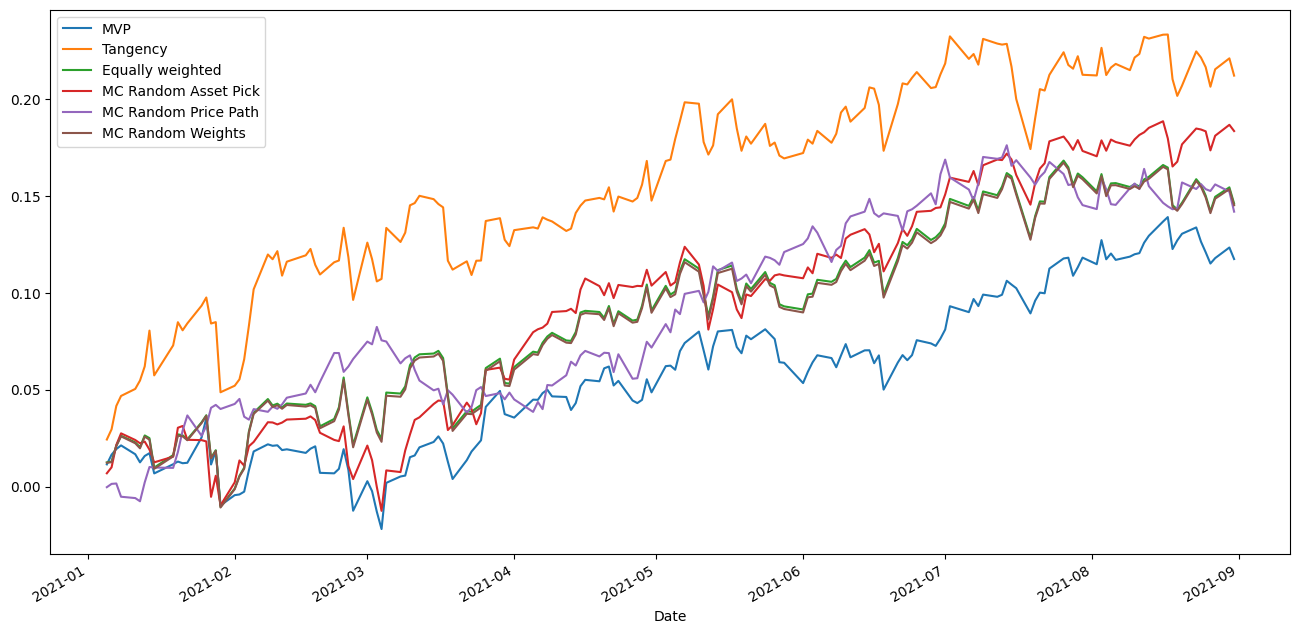

In [17]:
plot_cumulative_returns(portfolio_returns_df)

### **Step 4**

[*********************100%%**********************]  5 of 5 completed


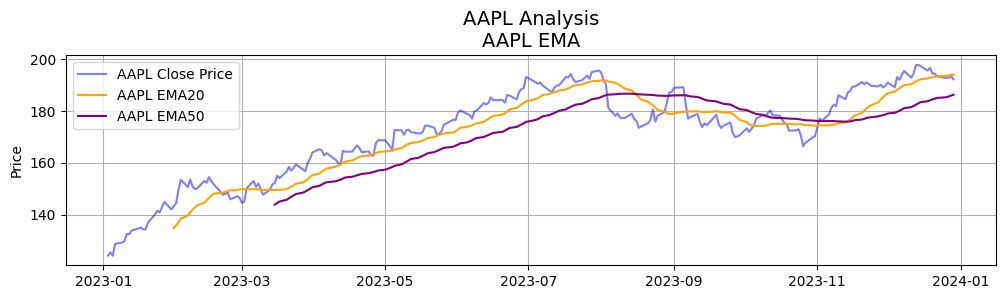

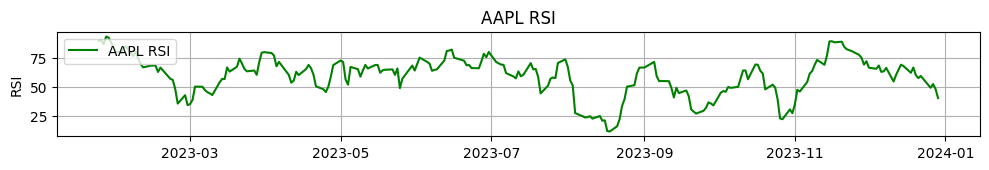

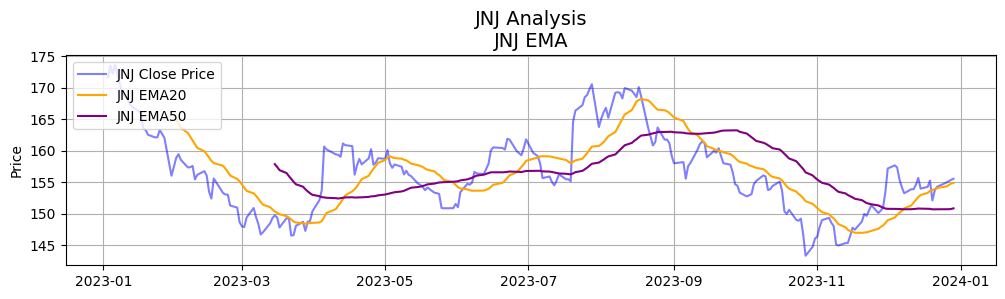

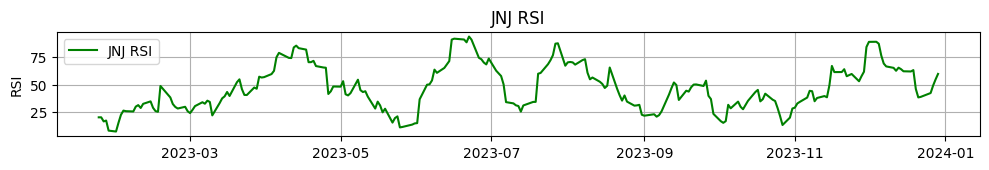

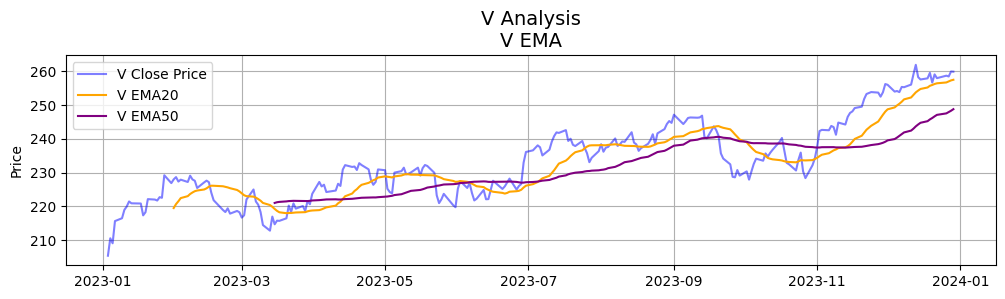

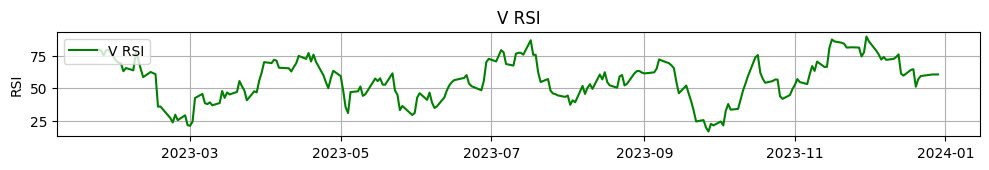

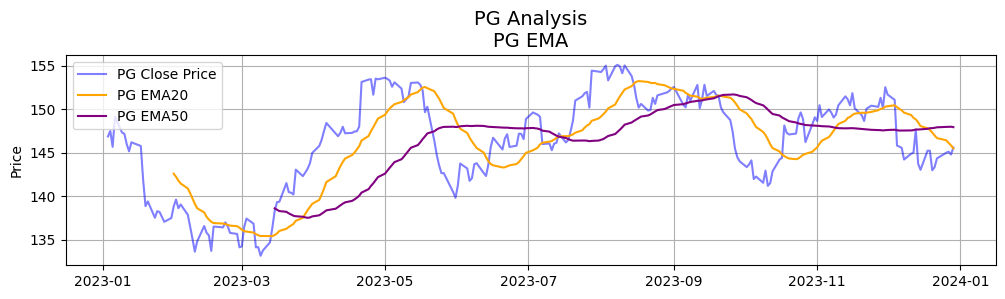

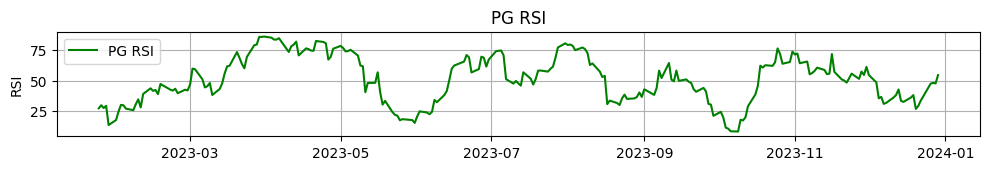

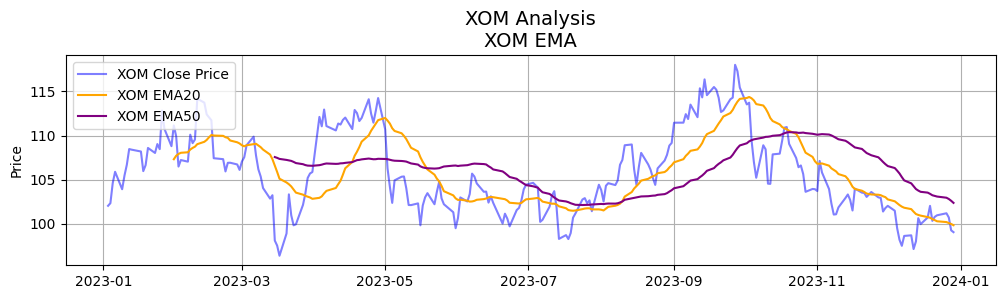

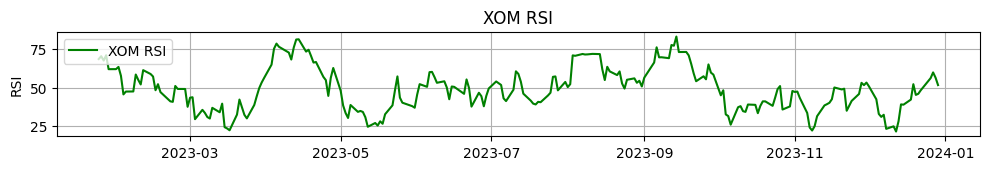

In [18]:
# Define date range
start_date = '2023-01-01'
end_date = '2024-01-01'

# Download stock data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
# Calculate EMA20 and EMA50
for stock in tickers:
    data[f'EMA20_{stock}'] = data[stock].rolling(window=20).mean()
    data[f'EMA50_{stock}'] = data[stock].rolling(window=50).mean()

# Calculate RSI
def calculate_rsi(close):
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

for stock in tickers:
    data[f'RSI_{stock}'] = calculate_rsi(data[stock])

# Plotting


for i, stock in enumerate(tickers, start=1):
    plt.figure(figsize=(12, 6))

    # Subplot: EMA
    plt.subplot(2, 1, 1)
    plt.plot(data.index, data[stock], label=f'{stock} Close Price', color='blue', alpha=0.5)
    plt.plot(data.index, data[f'EMA20_{stock}'], label=f'{stock} EMA20', color='orange')
    plt.plot(data.index, data[f'EMA50_{stock}'], label=f'{stock} EMA50', color='purple')
    plt.title(f'{stock} Analysis\n'.join(['', f'{stock} EMA']), fontsize=14)
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.grid()

    # Subplot: RSI
    plt.figure(figsize=(10, 3))
    plt.subplot(2, 1, 2)
    plt.plot(data.index, data[f'RSI_{stock}'], label=f'{stock} RSI', color='green')
    plt.title(f'{stock} RSI')
    plt.ylabel('RSI')
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()
    plt.show()



In [19]:
start_date = '2021-01-01'
end_date = '2021-09-01'
# Function to download historical price data from Yahoo Finance
def download_price_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Function to calculate returns
def calculate_returns(prices):
    returns = prices.pct_change().dropna()
    return returns

# Function to calculate beta using linear regression
def calculate_beta(returns_asset, returns_market):
    X = returns_market.values.reshape(-1, 1)
    y = returns_asset.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)
    beta = model.coef_[0][0]
    return beta

# Function to optimize portfolio weights using CAPM
def optimize_weights(beta_assets):
    total_beta = np.sum(beta_assets)
    optimized_weights = beta_assets / total_beta
    return optimized_weights

def ticker_weights(tickers):
    mcaps = {}
    for t in tickers:
        stock = yf.Ticker(t)
        mcaps[t] = stock.info["marketCap"]
    total_market_cap = sum(mcaps.values())
    weights = {ticker: mcaps[ticker] / total_market_cap for ticker in mcaps}
    return list(weights.values())


In [20]:
market = ['SPY']
returns_assets = calculate_returns(download_price_data(tickers, start_date, end_date))
returns_market = calculate_returns(download_price_data(market, start_date, end_date))


[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed


In [21]:
# Calculate beta for each asset
beta_assets = [calculate_beta(returns_asset, returns_market) for _, returns_asset in returns_assets.items()]
# Assume a risk-free rate (e.g., 10-year Treasury yield)
risk_free = yf.download("^IRX", start_date, end_date)["Adj Close"].apply(lambda x: (1 + x) ** (1/365) - 1)
risk_free_rate=risk_free.mean()

[*********************100%%**********************]  1 of 1 completed


In [22]:
# Portfolio weights using CAPM
capm_weights = optimize_weights(beta_assets)
capm_weights

array([0.32907479, 0.10460161, 0.09275544, 0.24459978, 0.22896838])

In [23]:
beta_assets

[1.4214425371987953,
 0.4518279134231845,
 0.40065822779086474,
 1.056551702609349,
 0.9890316615458296]

In [24]:
from sklearn.covariance import LedoitWolf
sigma=LedoitWolf(block_size=1000,
        store_precision=False).fit(returns_assets).covariance_*252
cov_df = pd.DataFrame(sigma, columns=tickers, index=tickers)
sigma

array([[0.06473948, 0.00622033, 0.00440694, 0.01841383, 0.0005876 ],
       [0.00622033, 0.02333399, 0.0108003 , 0.00680593, 0.00580583],
       [0.00440694, 0.0108003 , 0.02433343, 0.00935999, 0.0006555 ],
       [0.01841383, 0.00680593, 0.00935999, 0.04619863, 0.01091516],
       [0.0005876 , 0.00580583, 0.0006555 , 0.01091516, 0.09301772]])

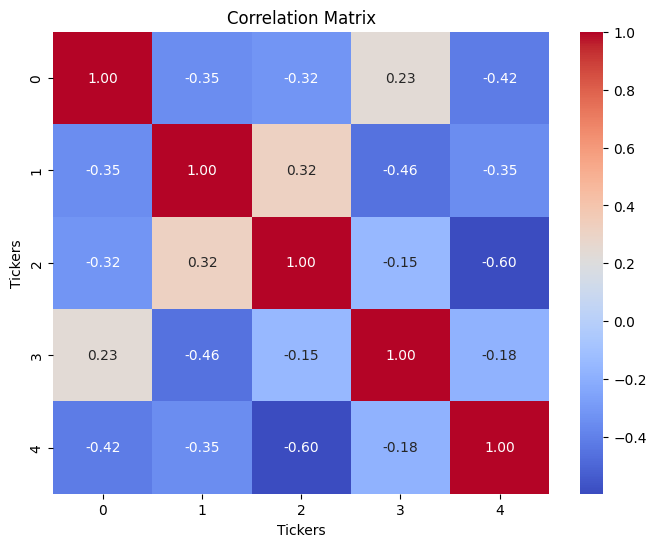

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(np.corrcoef(cov_df), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.xlabel('Tickers')
plt.ylabel('Tickers')
plt.show()

In [26]:
expected_market_return = returns_market.mean()
# Calculate variance of market returns
variance_market_returns = returns_market.var()
# Calculate delta
delta_risk_aversion = (expected_market_return - risk_free_rate) / variance_market_returns
delta_risk_aversion

19.405088921948042

In [27]:
# Compute equilibrium excess returns for each asset
equilibrium_returns = delta_risk_aversion * np.dot(sigma, capm_weights)
equilibrium_returns

array([0.52397845, 0.16462488, 0.14120185, 0.41602625, 0.48181721])

In [28]:
portfolio_variance_prior = np.dot(np.dot(equilibrium_returns, sigma), equilibrium_returns)
portfolio_std_dev = np.sqrt(portfolio_variance_prior)

print("Prior Standard Deviation (Variance):", portfolio_std_dev)
prior_sharpe_ratio = (np.mean(equilibrium_returns) - risk_free_rate) / np.sqrt(portfolio_variance_prior)
prior_sharpe_ratio

Prior Standard Deviation (Variance): 0.2577826137456564


1.3400655543457045

In [29]:
pi = equilibrium_returns
prior_mean_returns = pi.mean()
prior_mean_returns

0.3455297267608784

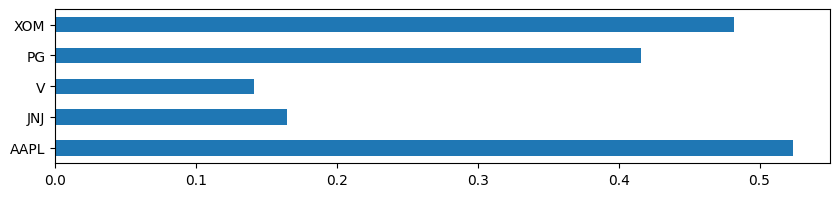

In [30]:
pd.Series(equilibrium_returns, index=tickers).plot.barh(figsize=(10,2));

In [31]:
intervals = [
    (0.04,0.10,0.68),
    (0.03, 0.23, 0.68),
    (0.06, 0.10, 0.68),
    (-0.02, 0.14, 0.68),
    (0.11, 0.37, 0.68)
]

In [32]:
import scipy.stats as stats
def quantify_views(lower_bound, upper_bound, confidence_level):
    # Calculate mean
    mean = (lower_bound + upper_bound) / 2

    # Calculate standard deviation
    z_value = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    std_dev = (upper_bound - lower_bound) / (2 * z_value)
    variance = std_dev**2

    return mean, variance

In [33]:
Q = []
omega = []

# Calculate mean and variance for each interval
for lower, upper, confidence_level in intervals:
    mean, variance = quantify_views(lower, upper, confidence_level)
    Q.append(mean)
    omega.append(variance)
Q = np.array(Q)
Q

array([0.07, 0.13, 0.08, 0.06, 0.24])

In [34]:
omega = np.diag(omega)
omega

array([[0.00091006, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01011177, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00040447, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00647153, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.01708889]])

In [35]:
viewdict = dict(zip(tickers, Q))
viewdict

{'AAPL': 0.07, 'JNJ': 0.13, 'V': 0.08, 'PG': 0.060000000000000005, 'XOM': 0.24}

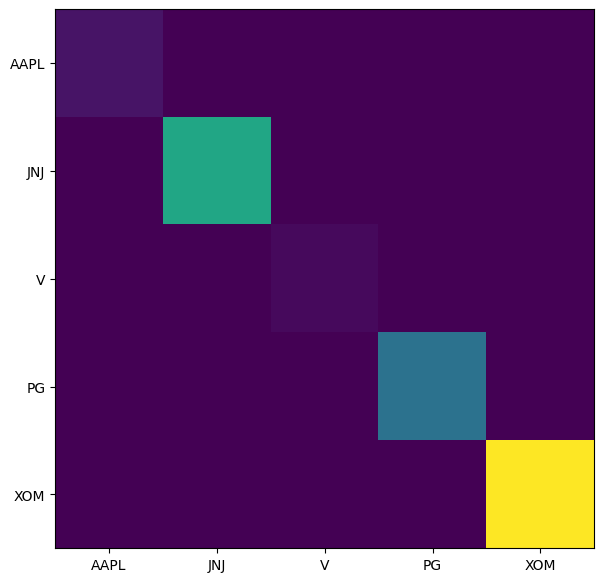

In [36]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(tickers)))
ax.set_yticks(np.arange(len(tickers)))

ax.set_xticklabels(tickers)
ax.set_yticklabels(tickers)
plt.show()

In [37]:
P = np.array([[1, 0, 0,0,0 ],
              [0, 1, 0,0,0],
              [0, 0, 1,0,0],
              [0, 0, 0,1,0],
              [0, 0, 0,0,1]])

In [38]:
def calculate_posterior_means_and_covariance(P, Q, pi, omega, tau, sigma):

    # Calculate inverse of omega
    omega_inv = np.linalg.inv(omega)

    # Calculate (tau * sigma)^(-1)
    tau_sigma_inv = np.linalg.inv((1 + tau) * sigma)

    # Calculate P^T * omega^(-1) * P
    P_transpose_omega_inv_P = np.dot(np.dot(P.T, omega_inv), P)

    # Calculate P^T * omega^(-1) * Q
    P_transpose_omega_inv_Q = np.dot(np.dot(P.T, omega_inv), Q)

    # Calculate first part of the expression
    first_part = np.linalg.inv(tau_sigma_inv + P_transpose_omega_inv_P)

    # Calculate second part of the expression
    second_part = np.dot(tau_sigma_inv, pi) + P_transpose_omega_inv_Q

    # Calculate expected return
    posterior_means = np.dot(first_part, second_part)

    expected_covariance = sigma + first_part

    return posterior_means, expected_covariance

posterior_means, expected_covariance = calculate_posterior_means_and_covariance(P, Q, pi, omega, 0.2, cov_df)

In [39]:
posterior_means


array([0.0743523 , 0.1177278 , 0.08010049, 0.08482406, 0.26608432])

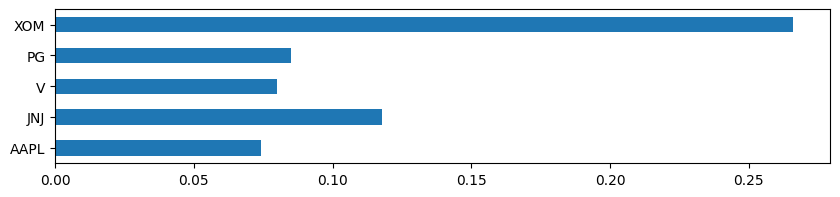

In [40]:
pd.Series(posterior_means, index=tickers).plot.barh(figsize=(10,2));

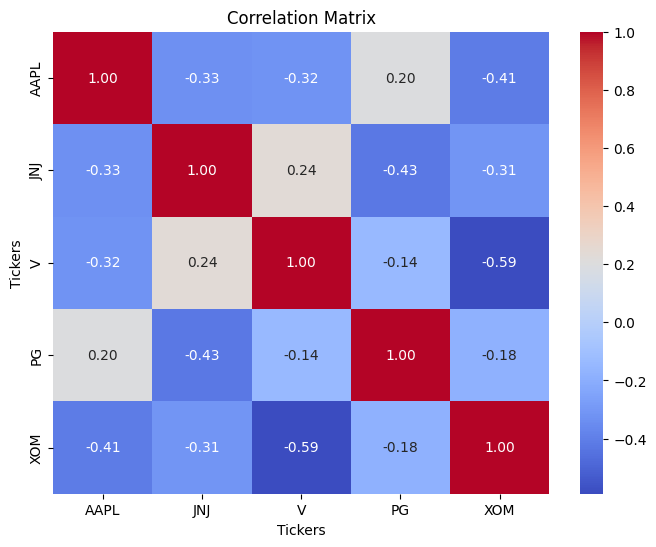

In [41]:
correlation_matrix = np.corrcoef(expected_covariance)

# Create a DataFrame for the correlation matrix
correlation_df = pd.DataFrame(correlation_matrix, index=tickers, columns=tickers)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.xlabel('Tickers')
plt.ylabel('Tickers')
plt.show()

In [42]:
post_pi_df = pd.Series(posterior_means, index=tickers)


In [43]:
rets_df = pd.DataFrame([pi, post_pi_df, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df.index = tickers
rets_df

,Prior,Posterior,Views
AAPL,0.52398,0.07435,0.07000
JNJ,0.16462,0.11773,0.13000
V,0.14120,0.08010,0.08000
PG,0.41603,0.08482,0.06000
XOM,0.48182,0.26608,0.24000


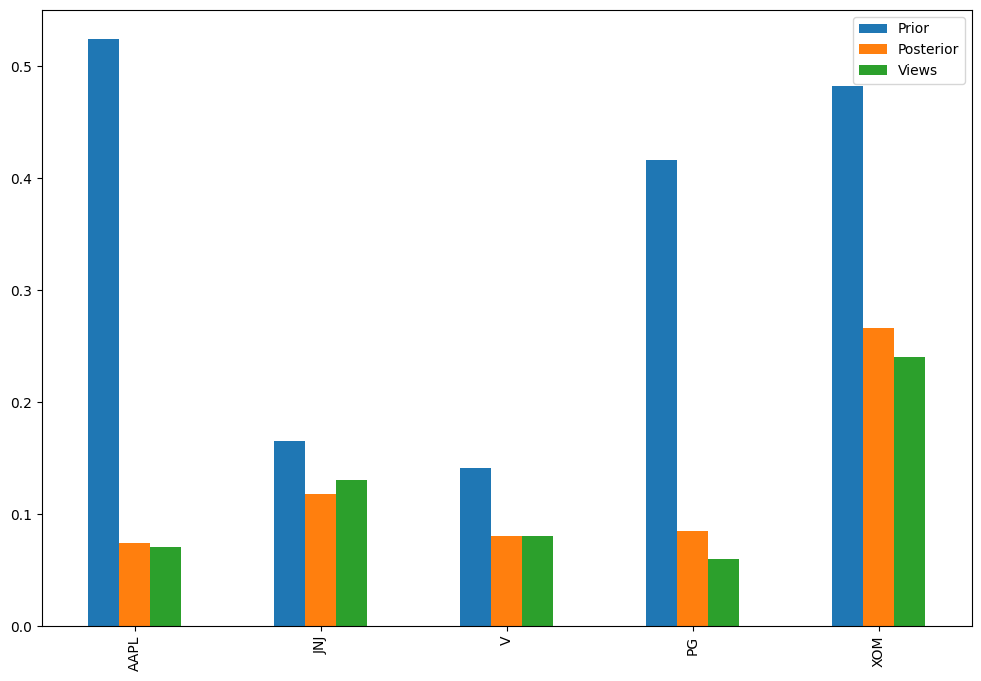

In [44]:
rets_df.plot.bar(figsize=(12,8));

In [45]:
import cvxpy as cp
import numpy as np

def portfolio_optimization(returns,  covariance_matrix ):
  n_assets = len(tickers)
  weights = cp.Variable(n_assets)
  constraints = [
      cp.sum(weights) == 1,
      weights >= 0
  ]
  mean_returns = np.mean(returns)
  portfolio_variance = cp.quad_form(weights, covariance_matrix)
  portfolio_return = cp.sum(mean_returns * weights)
  objective = cp.Minimize(cp.power(portfolio_variance, 0.5))
  problem = cp.Problem(objective, constraints)
  problem.solve(qcp=True)
  return weights.value

#bl_optimized_weights = portfolio_optimization(posterior_means, expected_covariance)
#bl_optimized_weights

In [46]:

def optimize_weights_ef(posterior_means, expected_covariance):
    n_assets = posterior_means.shape[0]
    weights_ef = cp.Variable(n_assets)
    returns_ef = np.array(posterior_means.mean()) * weights_ef
    risk_ef = cp.quad_form(weights_ef, expected_covariance)

    objective = cp.Minimize(1/2 * risk_ef - cp.sum(returns_ef))

    constraints = [cp.sum(weights_ef) == 1, weights_ef >= 0, returns_ef <= posterior_means]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return weights_ef.value

# Example usage:
bl_optimized_weights = optimize_weights_ef(posterior_means, expected_covariance)
bl_optimized_weights

array([0.1382676 , 0.25770005, 0.40125865, 0.09770122, 0.10507248])

In [47]:
bl_optimized_returns = np.dot(posterior_means, bl_optimized_weights)
bl_optimized_returns

0.10900554232259155

In [48]:
portfolio_variance_bl = np.dot(np.dot(posterior_means, expected_covariance), posterior_means)
portfolio_std_dev = np.sqrt(portfolio_variance_bl)

print("Standard Deviation (Variance):", portfolio_std_dev)
sharpe_ratio = (np.mean(np.dot(bl_optimized_weights, posterior_means)) - risk_free_rate) / np.sqrt(portfolio_variance_bl)
sharpe_ratio

Standard Deviation (Variance): 0.10363134531396961


1.0510470207780669

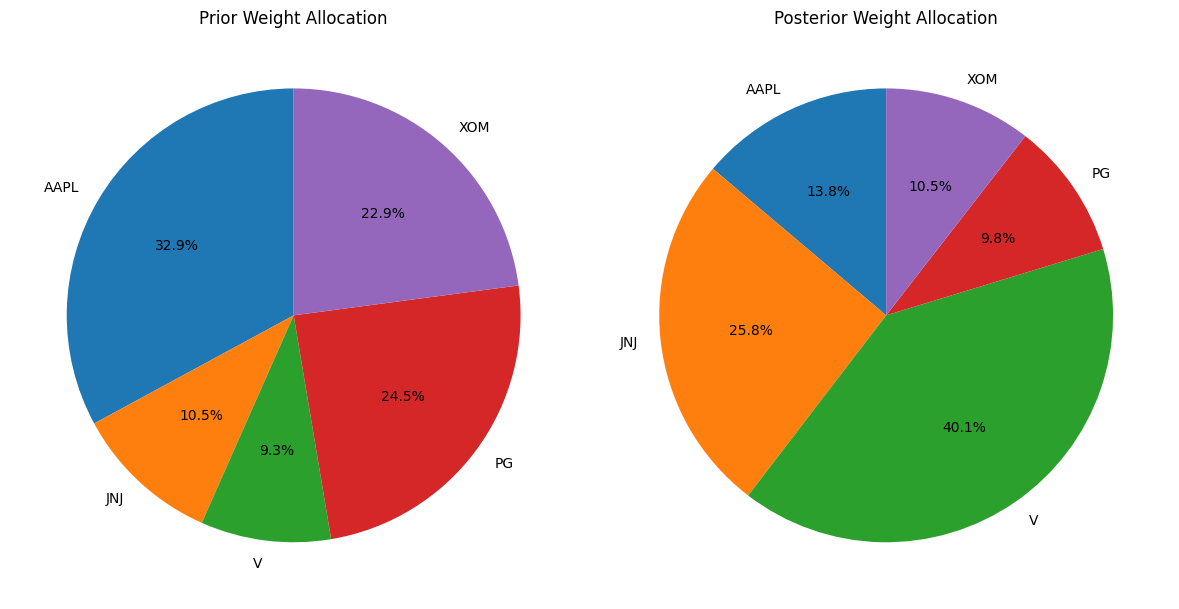

In [49]:
# Create Series for prior and posterior weights
prior_series = pd.Series(capm_weights, index=tickers, name='Prior Weights')
posterior_series = pd.Series(bl_optimized_weights, index=tickers, name='Posterior Weights')

# Plot pie chart to compare weight allocations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

prior_series.plot(kind='pie', autopct='%1.1f%%', ax=axes[0], startangle=90)
axes[0].set_ylabel('')
axes[0].set_title('Prior Weight Allocation')

posterior_series.plot(kind='pie', autopct='%1.1f%%', ax=axes[1], startangle=90)
axes[1].set_ylabel('')
axes[1].set_title('Posterior Weight Allocation')

plt.tight_layout()
plt.show()

### Step 5

In [50]:
def optimize_kelly(returns, risk_free, lookback, kelly_level):
    mean = returns.expanding(lookback).mean().dropna().values
    cov = returns.expanding(lookback).cov().dropna().values
    cov = cov.reshape(returns.shape[0] - lookback + 1, returns.shape[1], returns.shape[1])
    rf = risk_free.expanding(lookback).mean().dropna().values

    weights = np.zeros_like(mean)
    for i in range(mean.shape[0]):
        n = mean.shape[1]
        f = cp.Variable(n)

        constraints = [cp.sum(f) == 1 - rf[i], f >= 0]
        objective = cp.Maximize(rf[i] + cp.sum(cp.multiply(f, (mean[i] - rf[i]))) - cp.quad_form(f, cov[i]) / 2)
        problem = cp.Problem(objective, constraints)
        problem.solve()
        weights[i] = f.value

    return weights * kelly_level

Window size: 15
Mean: 
half_kelly     0.00071
full_kelly     0.00141
double_kelly   0.00282
triple_kelly   0.00424
dtype: float64
Volatility: 
half_kelly     0.00940
full_kelly     0.01880
double_kelly   0.03761
triple_kelly   0.05641
dtype: float64


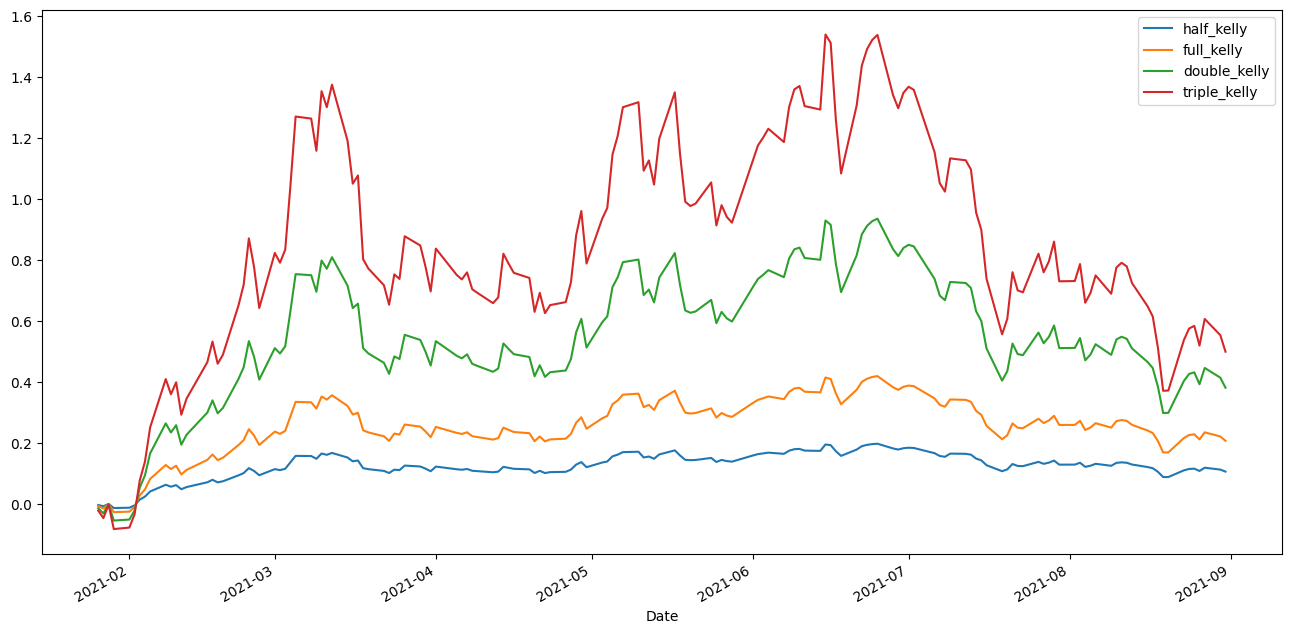

Window size: 30
Mean: 
half_kelly     0.00028
full_kelly     0.00055
double_kelly   0.00111
triple_kelly   0.00166
dtype: float64
Volatility: 
half_kelly     0.00916
full_kelly     0.01833
double_kelly   0.03665
triple_kelly   0.05498
dtype: float64


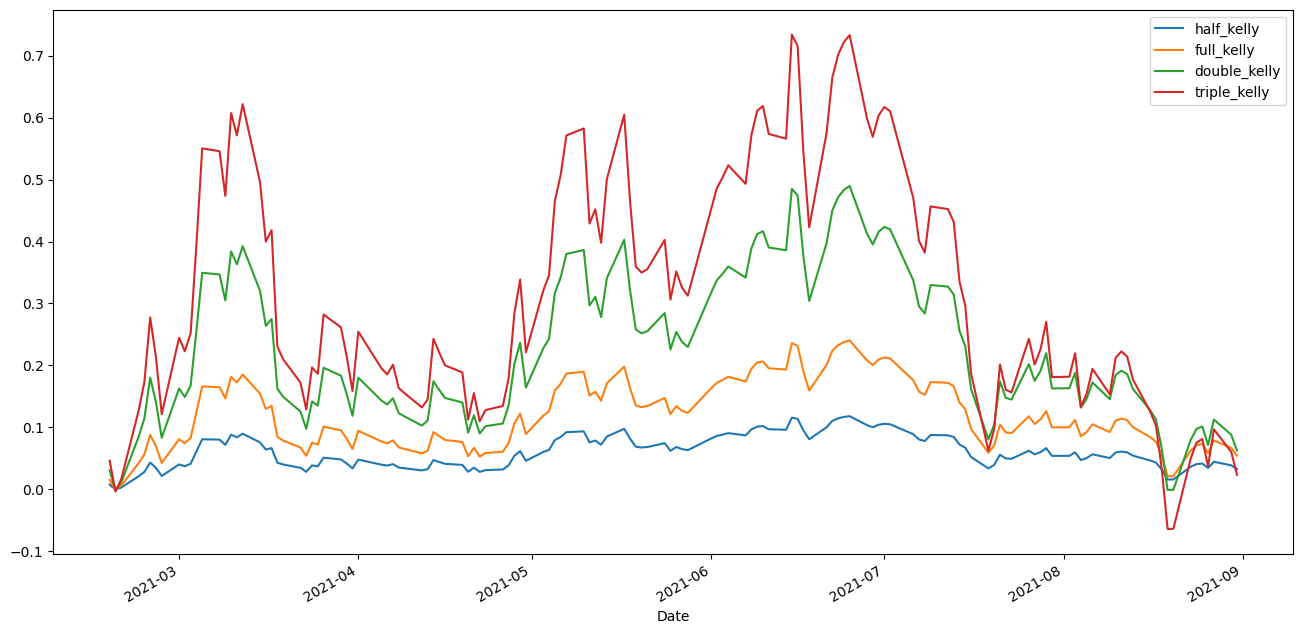

Window size: 60
Mean: 
half_kelly     -0.00004
full_kelly     -0.00009
double_kelly   -0.00018
triple_kelly   -0.00027
dtype: float64
Volatility: 
half_kelly     0.00863
full_kelly     0.01727
double_kelly   0.03453
triple_kelly   0.05180
dtype: float64


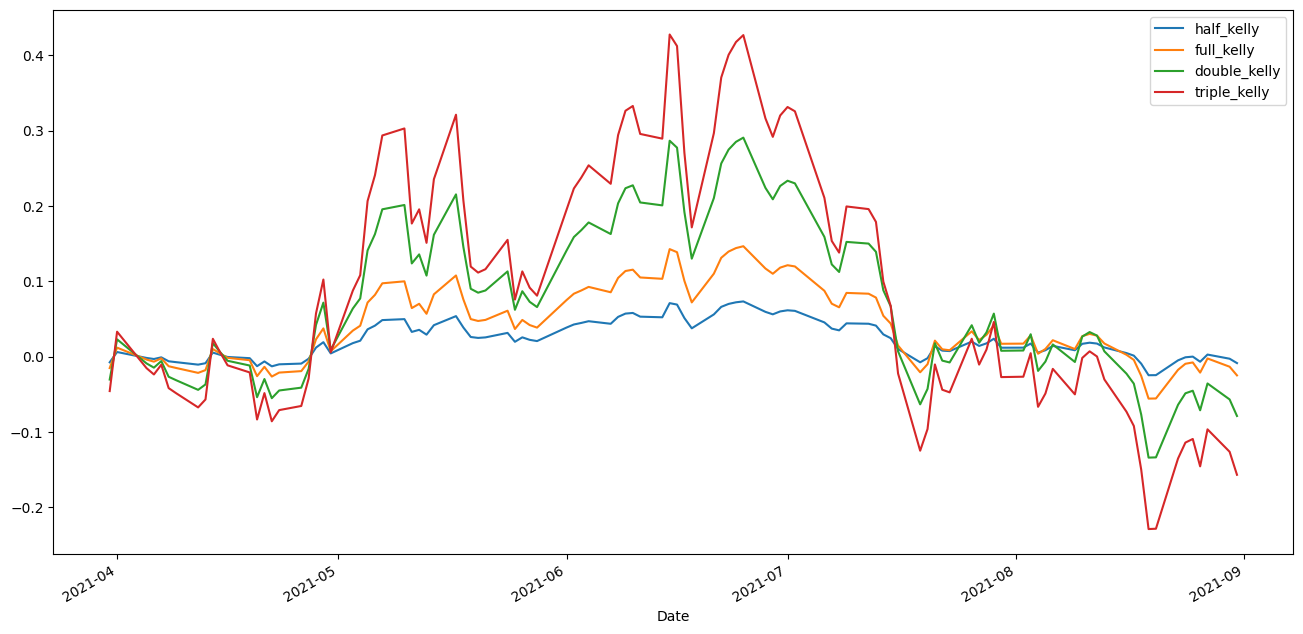

In [51]:
lookback = [15, 30, 60]

for i in lookback:
    half_kelly = optimize_kelly(returns, risk_free, i, 0.5)
    full_kelly = optimize_kelly(returns, risk_free, i, 1)
    double_kelly = optimize_kelly(returns, risk_free, i, 2)
    triple_kelly = optimize_kelly(returns, risk_free, i, 3)
    kelly_returns = pd.DataFrame()
    
    kelly_returns['half_kelly'] = np.sum(returns.iloc[len(returns) - half_kelly.shape[0]:, :] * half_kelly, axis=1)
    kelly_returns['full_kelly'] = np.sum(returns.iloc[len(returns) - full_kelly.shape[0]:, :] * full_kelly, axis=1)
    kelly_returns['double_kelly'] = np.sum(returns.iloc[len(returns) - double_kelly.shape[0]:, :] * double_kelly, axis=1)
    kelly_returns['triple_kelly'] = np.sum(returns.iloc[len(returns) - triple_kelly.shape[0]:, :] * triple_kelly, axis=1)

    print(f'Window size: {i}')
    print(f'Mean: \n{kelly_returns.mean()}')
    print(f'Volatility: \n{kelly_returns.std()}')
    plot_cumulative_returns(kelly_returns)
    plt.show()